## Independent Analysis 2 - Srinivas (handle: thewickedaxe)
** PLEASE SCROLL TO THE BOTTOM OF THE NOTEBOOK TO FIND THE QUESTIONS AND THEIR ANSWERS AND OTHER GENERAL FINDINGS**

** In this notebook we explore throwing out all the data except the basal ganglia and attempting to classify the data**

### Initial Data Cleaning

In [362]:
# Standard
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Dimensionality reduction and Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import manifold, datasets
from sklearn import preprocessing
from itertools import cycle

# Plotting tools and classifiers
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut


# Let's read the data in and clean it

def get_NaNs(df):
    columns = list(df.columns.get_values()) 
    row_metrics = df.isnull().sum(axis=1)
    rows_with_na = []
    for i, x in enumerate(row_metrics):
        if x > 0: rows_with_na.append(i)
    return rows_with_na

def remove_NaNs(df):
    rows_with_na = get_NaNs(df)
    cleansed_df = df.drop(df.index[rows_with_na], inplace=False)     
    return cleansed_df

initial_data = pd.DataFrame.from_csv('Data_Adults_1_reduced_2.csv')
cleansed_df = remove_NaNs(initial_data)

# Let's also get rid of nominal data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X = cleansed_df.select_dtypes(include=numerics)
print X.shape

(6785, 10)


we've now dropped the last of the discrete numerical inexplicable data, and removed children from the mix

### Extracting the samples we are interested in

In [364]:
# Let's extract ADHd and Bipolar patients (mutually exclusive)

ADHD = X.loc[X['ADHD'] == 1]
ADHD = ADHD.loc[ADHD['Bipolar'] == 0]

BP = X.loc[X['Bipolar'] == 1]
BP = BP.loc[BP['ADHD'] == 0]

print ADHD.shape
print BP.shape

# Keeping a backup of the data frame object because numpy arrays don't play well with certain scikit functions
ADHD = pd.DataFrame(ADHD.drop(['Patient_ID', 'Age', 'ADHD', 'Bipolar'], axis = 1, inplace = False))
BP = pd.DataFrame(BP.drop(['Patient_ID', 'Age', 'ADHD', 'Bipolar'], axis = 1, inplace = False))

print ADHD.shape
print BP.shape

(2370, 10)
(793, 10)
(2370, 6)
(793, 6)


### Clustering and other grouping experiments

In [365]:
ADHD_clust = pd.DataFrame(ADHD)
BP_clust = pd.DataFrame(BP)

# This is a consequence of how we dropped columns, I apologize for the hacky code 
data = pd.concat([ADHD_clust, BP_clust])

#### K-Means clustering

In [366]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(data.get_values())
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
print('Estimated number of clusters: %d' % len(cluster_centers))
print data.shape

Estimated number of clusters: 2
(3163, 6)


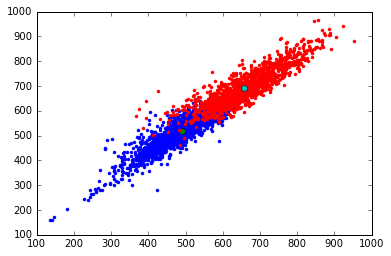

In [367]:
for label in [0, 1]:
    ds = data.get_values()[np.where(labels == label)]    
    plt.plot(ds[:,0], ds[:,1], '.')    
    lines = plt.plot(cluster_centers[label,0], cluster_centers[label,1], 'o')

### Classification Experiments

Let's experiment with a bunch of classifiers

In [375]:
ADHD_iso = pd.DataFrame(ADHD_clust)
BP_iso = pd.DataFrame(BP_clust)

In [376]:
BP_iso['ADHD-Bipolar'] = 0
ADHD_iso['ADHD-Bipolar'] = 1
print BP_iso.columns
data = pd.DataFrame(pd.concat([ADHD_iso, BP_iso]))
class_labels = data['ADHD-Bipolar']
data = data.drop(['ADHD-Bipolar'], axis = 1, inplace = False)
print data.shape
data = data.get_values()

Index([u'Concentration_Caudate_L', u'Concentration_Caudate_R',
       u'Concentration_Pallidum_L', u'Concentration_Pallidum_R',
       u'Concentration_Putamen_L', u'Concentration_Putamen_R',
       u'ADHD-Bipolar'],
      dtype='object')
(3163, 6)


In [377]:
# Leave one Out cross validation
def leave_one_out(classifier, values, labels):
    leave_one_out_validator = LeaveOneOut(len(values))
    classifier_metrics = cross_validation.cross_val_score(classifier, values, labels, cv=leave_one_out_validator)
    accuracy = classifier_metrics.mean()
    deviation = classifier_metrics.std()
    return accuracy, deviation

In [378]:
svc = SVC(gamma = 2, C = 1)
bc = BaggingClassifier(n_estimators = 22)
gb = GradientBoostingClassifier()
dt = DecisionTreeClassifier(max_depth = 22) 
qda = QDA()
gnb = GaussianNB()
vc = VotingClassifier(estimators=[('gb', gb), ('bc', bc), ('gnb', gnb)],voting='hard')
classifier_accuracy_list = []
classifiers = [(gnb, "Gaussian NB"), (qda, "QDA"), (svc, "SVM"), (bc, "Bagging Classifier"), (vc, "Voting Classifier"),
               (dt, "Decision Trees")]
for classifier, name in classifiers:
    accuracy, deviation = leave_one_out(classifier, data, class_labels)
    print '%s accuracy is %0.4f (+/- %0.3f)' % (name, accuracy, deviation)
    classifier_accuracy_list.append((name, accuracy))

Gaussian NB accuracy is 0.7493 (+/- 0.433)
QDA accuracy is 0.7401 (+/- 0.439)
SVM accuracy is 0.7483 (+/- 0.434)
Bagging Classifier accuracy is 0.7041 (+/- 0.456)
Voting Classifier accuracy is 0.7458 (+/- 0.435)
Decision Trees accuracy is 0.6285 (+/- 0.483)


given the number of people who have ADHD and Bipolar disorder the chance line would be at around 0.6. The classifiers fall between 0.7 and 0.75 which makes them just barely better than chance. This is still an improvement over last time.

### Questions and Answers

##### 1) Literature Investigation
The data csv is a bit different this time. We threw out all the baseline values and only retained concentration values for the Putamen, Claudate and Pallidum, in addition to all regions marked "frontal". The rationale behind this a lot of the literature online says that the shape and size of the basal ganglia and the frontal lobe is affected by both ADHD and Bipolar disorder.

Given this extreme reduction in input dimensionality I expected the classifiers to be very successful.


##### 2) Mix and Match data and examine classifier performance
We tried mixing and matching various permutations and combinations of the concentration columns and the classifiers still were no better than chance.

This led me to question either the integrity of the data or if whether basal ganglia blood flow differences are captured in spect data. 


##### 3) Confirmatory Analysis
So we carried out a small experiment. Given the rCBF values for the basal ganglia and a label vector labelling patients as either suffering from ADHD or Bipolar disorder is there any clustering evident? Our ensemble classifers working on this dataset

#### Findings
1. The classifiers are still no better than chance even after eliminating all other noise
2. No clustering is really apparent